In [ ]:
!pip install -q Kaggle #This command will install the Kaggle library in Python, which allows you to access the Kaggle datasets

In [ ]:
#from google.colab import files
#files.upload()

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "-------------"///add username
os.environ['KAGGLE_KEY'] = "------------"///Add key

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!kaggle datasets download -d hsankesara/flickr-image-dataset

flickr-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip flickr-image-dataset.zip

Archive:  flickr-image-dataset.zip
replace flickr30k_images/flickr30k_images/1000092795.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install -q timm  #To use the timm package to classify images,
!pip install -q transformers #To use the transformers package to perform natural language processing

In [ ]:
import os #for file and system operations
import cv2  #for image processing
import gc  #
import numpy as np  #for garbage collection
import pandas as pd  #for numerical computation
import itertools #for iteration
from tqdm.autonotebook import tqdm #for progress bars
import albumentations as A  #for image augmentation
import matplotlib.pyplot as plt  #for plotting
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import torch  #for deep learning
from torch import nn
import torch.nn.functional as F  #for neural networks
import timm  #for image classification models
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
#These classes can be used to load, train, and evaluate DistilBERT models for a variety of natural language processing tasks

In [ ]:
dataset = "30k"

In [ ]:
!pip install -q pandas

In [ ]:
if dataset == "30k":
     # Read the Flickr30k dataset
  df = pd.read_csv(r"/content/flickr30k_images/results.csv", delimiter="|")
  df.columns = ['image', 'caption_number', 'caption']
  df['caption'] = df['caption'].str.lstrip()
  df['caption_number'] = df['caption_number'].str.lstrip()
  df.loc[19999, 'caption_number'] = "4"
  df.loc[19999, 'caption'] = "A dog runs across the grass ."
    # Create a unique id for each caption.
  ids = [id_ for id_ in range(len(df) // 5) for _ in range(5)]
  df['id'] = ids
    # Save the data to a file.
  df.to_csv("captions.csv", index=False)
  # Set the image path and captions path
  image_path = "/content/flickr30k_images/flickr30k_images"
  captions_path = "/content"
df.head()

,image,caption_number,caption,id
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,0
1,1000092795.jpg,1,"Two young , White males are outside near many ...",0
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,0
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,0
4,1000092795.jpg,4,Two friends enjoy time spent together .,0


In [ ]:
import torch

class CFG:
  # Data
    debug = False
    image_path = "/content/flickr30k_images/flickr30k_images"
    captions_path = "/content"
    # Training
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Models
    model_name = 'resnet152'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True
    trainable = True
    temperature = 1.0

    size = 224

    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1


In [ ]:
class AvgMeter:
  # Initialize the meter with a name
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


In [ ]:
class CLIPDataset(torch.utils.data.Dataset):
  #The CLIPDataset class is created to represent a dataset used for training a custom implementation of the CLIP model.
    def __init__(self, image_filenames, captions, tokenizer, transforms):

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [ ]:
#This ImageEncoder class serves as a wrapper for the timm image classification models and allows for customization of the model's architecture, pre-training, and fine-tuning behavior.
class ImageEncoder(nn.Module):
  #In the __init__ method, the class is initialized with optional parameters: model_name, pretrained, and trainable, which have default values based on CFG (configuration) settings

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
    #The timm.create_model function is used to create an image classification model based on the specified model_name.
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable
#The forward method defines the forward pass of the model.
    def forward(self, x):
        return self.model(x)

In [ ]:
#The TextEncoder class takes two parameters:

#model_name: The name of the DistilBert model to use.
#pretrained: Whether to use a pre-trained DistilBert model or a randomly initialized DistilBert model

class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [ ]:
#The ProjectionHead class takes two parameters:

#embedding_dim: The size of the image and text embeddings.
#projection_dim: The size of the projected space.

class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x


!nvidia-smi

In [ ]:
# The CLIPModel class takes two parameters:

#temperature: The temperature for the softmax distribution.
#image_embedding: The size of the image embedding.
#text_embedding: The size of the text embedding.

class CLIPModel(nn.Module):
  # This class implements the CLIP model, which is a text-image embedding model.
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [ ]:
# A simple Example

batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#The make_train_valid_dfs() function takes one input:
#dataframe: The dataset.
#The function then randomly splits the dataset into train and valid sets, with a 80/20 split. The train and valid dataframes are then returned.

def make_train_valid_dfs():
  # This function splits the dataset into train and valid sets.
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [ ]:
#The train_epoch() function takes five inputs:

#model: The model.
#train_loader: The train dataloader.
#optimizer: The optimizer.
#lr_scheduler: The learning rate scheduler.
#step: The step size, which can be "epoch" or "batch".

def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel(
        temperature=CFG.temperature,
        image_embedding=2048,  # Image embedding dimension for resnet152
        text_embedding=768,  # Text embedding dimension
    ).to(CFG.device)

    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]

    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "b1.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)


In [ ]:
#main()

In [ ]:
#!nvidia-smi

In [ ]:
def get_image_embeddings(valid_df, model_path):
  # This function gets the image embeddings for the valid set.
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [ ]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, r"/content/b1 (2).pt")

  0%|          | 0/994 [00:00<?, ?it/s]

In [ ]:
#The find_matches() function takes five inputs:
#model: The model.
#image_embeddings: The image embeddings.
#query: The query.
#image_filenames: The image filenames.
#n: The number of images to return.

def find_matches(model, image_embeddings, query, image_filenames, n=12):
  # This function finds the top `n` images that are most similar to the query.
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    selected_images = set()
    matches = []
    for idx in indices:
        if len(matches) >= n:
            break
        image_filename = image_filenames[idx]
        if image_filename not in selected_images:
            selected_images.add(image_filename)
            matches.append(image_filename)

    _, axes = plt.subplots(5, 5, figsize=(15, 15))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

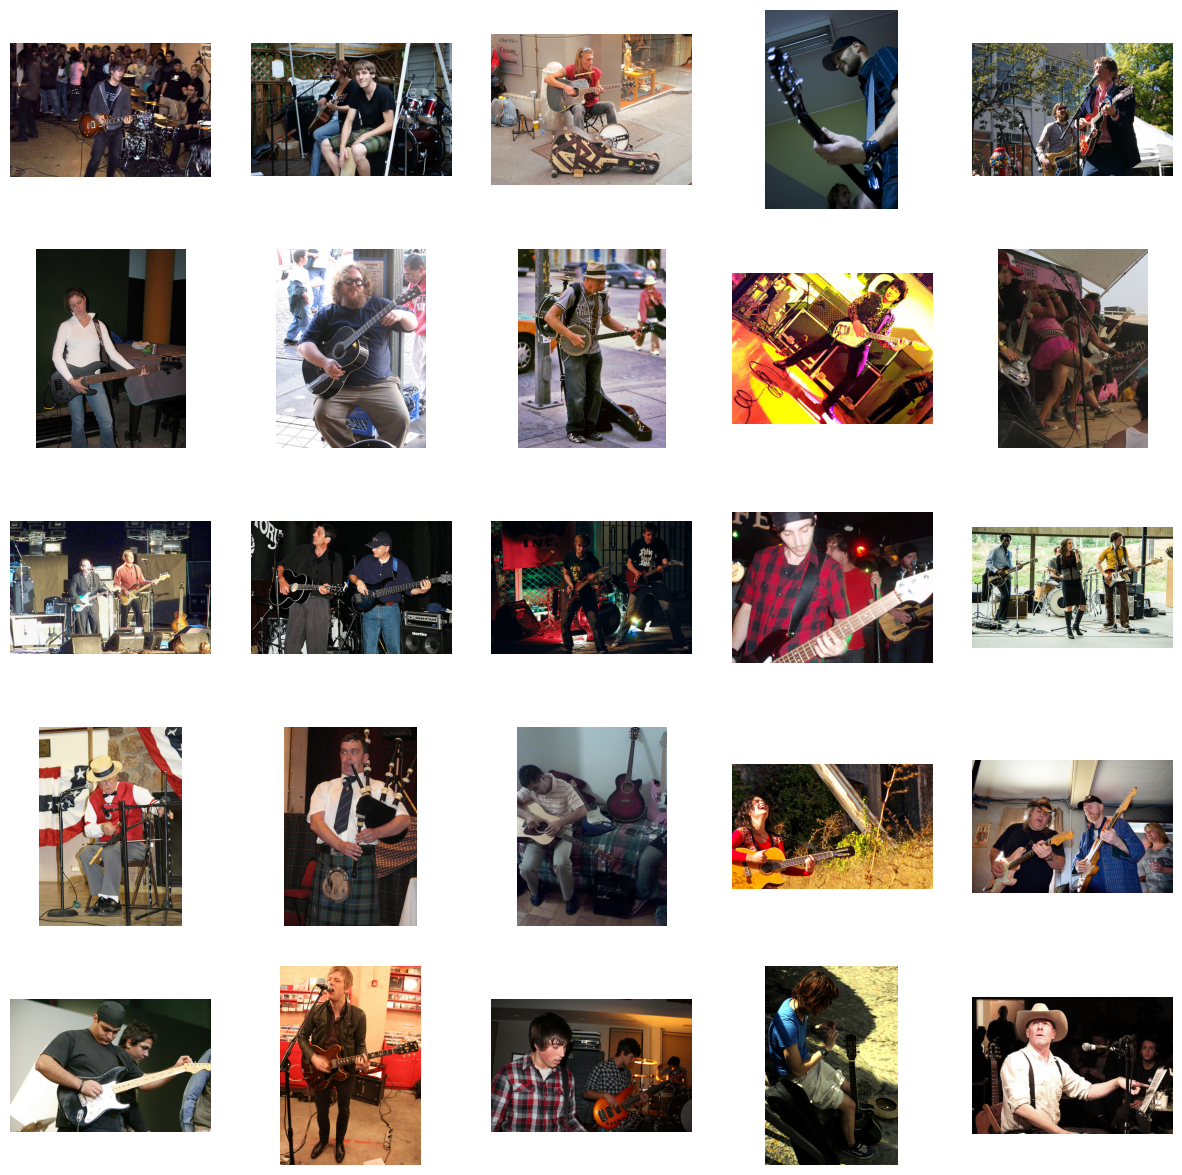

In [ ]:
find_matches(model,
             image_embeddings,
             query="man playing guitar",
             image_filenames=valid_df['image'].values,
             n=25)
